# Import dependencies 

In [3]:
import os

In [ ]:
#os.getcwd()

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

# Upload/create dataset

Data folder is created in the working directory. It includes two folders: "Happy" and "Sad"
Each folder contain images of happy/sad people from google search in format of jpg and png.
We will create a model which can classify pictures as happy or sad 

In [2]:
IMAGE_SIZE= 256 #Image size can be found in the image-right click Properties part.
BATCH_SIZE=32 #standard 


In [117]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 172 files belonging to 2 classes.


In [118]:
class_names = dataset.class_names
class_names

['happy', 'sad']

In [119]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1]


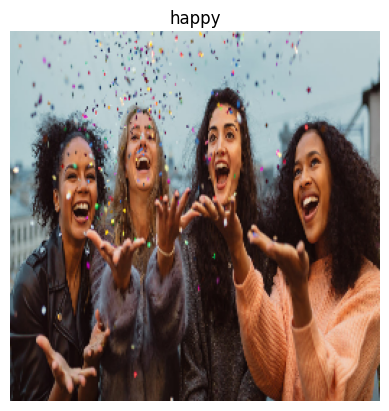

In [120]:
for image_batch, labels_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[0]])
    plt.axis("off")

In [11]:
len(dataset)
#actual size is : 6x 32 

6

# Create a function for partitioning dataset to training, test,validation


In [121]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.2, test_split=0.1, shuffle= True, shuffle_size=10000):
    ds_size= len(ds) 
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int (ds_size*train_split)
    val_size= int(ds_size*val_split)
    
    train_ds = ds.take(train_size)
    
    val_ds= ds.skip(train_size).take(val_size)
    test_ds=  ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [122]:
train_ds, val_ds, test_ds= get_dataset_partitions_tf (dataset)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

4
1
1


In [146]:
# Cache, Shuffle, and Prefetch the Dataset
# Make the model faster
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


# Build DL model 

In [136]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [59]:
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [137]:
n_classes=2 
CHANNELS=3
IMAGE_SIZE= 256 
BATCH_SIZE=32
#input_shape= (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
#input_shape= (256,256,3)
#input_shape= (IMAGE_SIZE, IMAGE_SIZE, CHANNELS) # 256,256,3

In [107]:
resize_and_rescale= tf.keras.Sequential([
   layers.experimental.preprocessing.Rescaling(IMAGE_SIZE, IMAGE_SIZE),
   layers.experimental.preprocessing.Rescaling(1.0/255),
])
#data augmentation
data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [147]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D()) #take the max value after relu activation

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten()) 
model.add(Dense(256, activation='relu')) # 256 neurons
model.add(Dense(1, activation='sigmoid')) # result will be either 0 or 1. we have 2 classes.



In [148]:
model.build(input_shape=input_shape)


In [149]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_62 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_63 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_62 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_64 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 30, 30, 32)     

# Model compile 

In [150]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])


# Model train

In [151]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=15,
)

Epoch 1/15


2023-03-03 15:00:10.810786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 202ms/step - loss: 681.4257 - accuracy: 0.6019 - val_loss: 44.1558 - val_accuracy: 0.5312
Epoch 2/15
1/4 [======>.......................] - ETA: 0s - loss: 59.8589 - accuracy: 0.4167

2023-03-03 15:00:11.721925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 124ms/step - loss: 21.7334 - accuracy: 0.5185 - val_loss: 15.0551 - val_accuracy: 0.4688
Epoch 3/15
4/4 [==============================] - 0s 114ms/step - loss: 11.8823 - accuracy: 0.4815 - val_loss: 0.5103 - val_accuracy: 0.7812
Epoch 4/15
4/4 [==============================] - 0s 120ms/step - loss: 0.8945 - accuracy: 0.6574 - val_loss: 0.8051 - val_accuracy: 0.5625
Epoch 5/15
4/4 [==============================] - 0s 103ms/step - loss: 0.6843 - accuracy: 0.7037 - val_loss: 0.3631 - val_accuracy: 0.7812
Epoch 6/15
4/4 [==============================] - 0s 112ms/step - loss: 0.3228 - accuracy: 0.8889 - val_loss: 0.4820 - val_accuracy: 0.8438
Epoch 7/15
4/4 [==============================] - 0s 100ms/step - loss: 0.2825 - accuracy: 0.8796 - val_loss: 0.4549 - val_accuracy: 0.8438
Epoch 8/15
4/4 [==============================] - 0s 98ms/step - loss: 0.2133 - accuracy: 0.9537 - val_loss: 0.3859 - val_accuracy: 0.8750
Epoch 9/15
4/4 [=============

In [152]:
model.evaluate(test_ds)

1/1 [==============================] - 0s 75ms/step - loss: 0.3223 - accuracy: 0.9062


[0.3222516179084778, 0.90625]

# Plot performance of the model

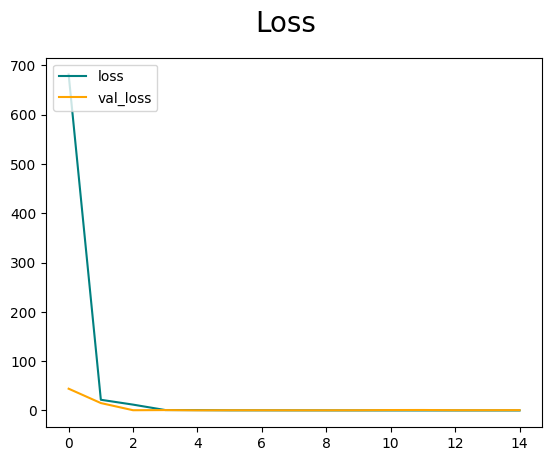

In [153]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

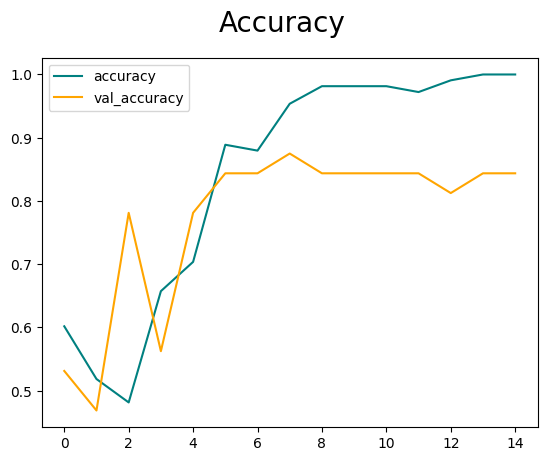

In [154]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Model performance on sample data

first image to predict
actual label: happy
1/1 [==============================] - 0s 29ms/step
predicted label: happy


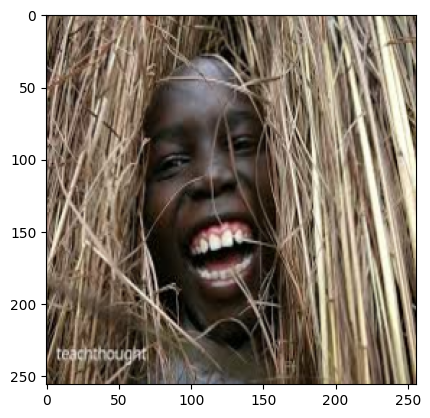

In [174]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])